# Investigation of Housing Price to District Amenities in Central London

## Coursera Capstone Project Notebook Analysis

### Introduction

This notebook uses clustering algorithms to segment different neighborhood in London depending on different metrics such as: 
<li> local amenity density </li>
<li> local restaurant density </li> 
<li> multi-ethnical restaurant density </li> 
<li> office amenity density </li> 
<li> access to TFL (Transport for London) </li>
<li> national railway services </li> 
<li> distance to high street venues </li>
<li> proximity to recreational locations </li> 

A map visualization of London is presented.

This notebook aims to aggregate datasets of London real estate price per neighborhood and find its correlation to local amenitities. This is to inform to potential investment opportunities in the area of London. 

<em>Discousure: The analysis provided in this notebook is illustrative only and does not intent to be an investment tool.</em>

### Data Sources

The following notebook aggregates several datasets from online repositories. The following lists the current datasets used as per August 2020.
<li>Wikipedia: <a href="https://en.wikipedia.org/wiki/London_postal_district?oldformat=true"> dataset</a> used to obtain postal codes and district names in GLA (Greater London Authority): </li>

<li>London Datastore: <a href="https://data.london.gov.uk/dataset/london-borough-profiles"> dataset</a> used to obtain the district prices in central London latest data up to March 2019</li>

<li>Foursquare API: Amenitites and location data obtain form Foursquare sandbox API</li>




## Code

We start by importing the relevant libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip install folium
import folium # map rendering library

# used to parse html websites
!pip install beautifulsoup4
from bs4 import BeautifulSoup

print('Libraries imported.')

Libraries imported.


First let's parse the wikipedia page containing all districts and post codes in London

In [2]:
import requests
wiki_url = 'https://en.wikipedia.org/wiki/London_postal_district?oldformat=true'
wiki_page = requests.get(wiki_url).text  # import the html text form the wikipedia page

soup = BeautifulSoup(wiki_page, 'html.parser') # use the BeautifulSOup package to parse the HTML 

In [3]:
# obtain the table data contained in the HTML
table = soup.select('table',{'class':'wikitable'})
links = table[1].find_all('td')

The function helps cleaning the nema

In [4]:
def split(txt, seps):
    """
    The function splits a string from a list of separators
    txt: string to split
    seps: list of separators
    """
    default_sep = 'HH' #seps[0]

    for sep in seps:
        txt = txt.replace(sep, default_sep,1)
    return [i.strip() for i in txt.split(default_sep)]

Now that we have isolated the data from the HTML we can proceed to prreprocess and clean the data.

In [5]:
list_items = []
postcodeArea = []
postcodes = []
district = []
neighborhood = []
neighborhood_names = []

# take all the content present in 'links' and copy to a new variable to have it in a list form
for index in links:
    list_items.append(index.text)

del list_items[0]
del list_items[9]    
del list_items[15]

postcodeArea = list_items[0:-13:3]
district = list_items[1:-13:3]
neighborhood = list_items[2:-13:3]

postcodeArea.append(list_items[15])
postcodeArea.append(list_items[20])
postcodeArea.append(list_items[25])
district.append(list_items[16])
district.append(list_items[18])
district.append(list_items[21])
district.append(list_items[23])
district.append(list_items[26])
neighborhood.append(list_items[17])
neighborhood.append(list_items[19])
neighborhood.append(list_items[22])
neighborhood.append(list_items[24])
neighborhood.append(list_items[27])

# clean up the data some entries do not have the space separator when parsing from html
neighborhood[0] = neighborhood[0].replace('HamE7', 'Ham E7')
neighborhood[0] = neighborhood[0].replace('LeytonstoneE12', 'Leytonstone E12')
neighborhood[1] = neighborhood[1].replace('districtEC2', 'district EC2')
neighborhood[1] = neighborhood[1].replace('BishopsgateEC3', 'Bishopsgate EC3')
neighborhood[1] = neighborhood[1].replace('StreetEC4', 'Street EC4')
neighborhood[2] = neighborhood[2].replace('HollowayN8', 'Holloway N8')
neighborhood[3] = neighborhood[3].replace('HillNW8', 'Hill NW8')
neighborhood[3] = neighborhood[3].replace("John's", "Johns")
neighborhood[3] = neighborhood[3].replace('WoodNW9', 'Wood NW9')
neighborhood[9] = neighborhood[9].replace('districtWC2', 'district WC2')

for code in neighborhood:
    split_array = code.split() # split by space
    for i in split_array: 
        if i.isalpha() == False:
            postcodes.append(i)
        else:
            continue

neighborhood_names0 = split(neighborhood[0], postcodes)
neighborhood_names1 = split(neighborhood[1], postcodes)
neighborhood_names2 = split(neighborhood[2], postcodes)
neighborhood_names3 = split(neighborhood[3], postcodes)
neighborhood_names4 = split(neighborhood[4], postcodes)
neighborhood_names5 = split(neighborhood[5], postcodes)
neighborhood_names6 = split(neighborhood[6], postcodes)
neighborhood_names7 = split(neighborhood[7], postcodes)
neighborhood_names8 = split(neighborhood[8], postcodes)
neighborhood_names9 = split(neighborhood[9], postcodes)


neighborhood_names0.pop(0)
neighborhood_names1.pop(0)
neighborhood_names2.pop(0)
neighborhood_names3.pop(0)
neighborhood_names4.pop(0)
neighborhood_names5.pop(0)
neighborhood_names6.pop(0)
neighborhood_names7.pop(0)
neighborhood_names8.pop(0)
neighborhood_names9.pop(0)

neighborhood_names0[0] = district[0]
neighborhood_names1[0] = district[1]
neighborhood_names2[0] = district[2]
neighborhood_names3[0] = district[3]
neighborhood_names4[0] = district[4]
neighborhood_names5[0] = district[5]
neighborhood_names6[0] = district[6]
neighborhood_names7[0] = district[7]
neighborhood_names8[0] = district[8]
neighborhood_names9[0] = district[9]

district0 = [district[0] for i in range(len(neighborhood_names0))]
district1 = [district[1] for i in range(len(neighborhood_names1))]
district2 = [district[2] for i in range(len(neighborhood_names2))]
district3 = [district[3] for i in range(len(neighborhood_names3))]
district4 = [district[4] for i in range(len(neighborhood_names4))]
district5 = [district[5] for i in range(len(neighborhood_names5))]
district6 = [district[6] for i in range(len(neighborhood_names6))]
district7 = [district[7] for i in range(len(neighborhood_names7))]
district8 = [district[8] for i in range(len(neighborhood_names8))]
district9 = [district[9] for i in range(len(neighborhood_names9))]


neighborhood_names = neighborhood_names0+neighborhood_names1+neighborhood_names2+neighborhood_names3 + neighborhood_names4 +neighborhood_names5 +neighborhood_names6 +neighborhood_names7 +neighborhood_names8 +neighborhood_names9
district_names = district0 +district1 +district2 +district3 +district4 +district5 +district6 +district7 +district8 +district9
print('There are', len(postcodes), 'postcodes in London')
print('There are', len(district), 'districts in London')
print('There are', len(neighborhood_names), 'neighborhoods in London')



df_postcodes = pd.DataFrame(postcodes)
df_district = pd.DataFrame(district_names)
df_neighborhood = pd.DataFrame(neighborhood_names)

df_london = pd.concat([df_postcodes, df_district, df_neighborhood], axis=1)
columns_name = ['PostalCode', 'District', 'Neighborhood']
df_london.columns = columns_name
df_london.head()

There are 120 postcodes in London
There are 10 districts in London
There are 120 neighborhoods in London


,PostalCode,District,Neighborhood
0,E1,Eastern,Eastern
1,E2,Eastern,Bethnal Green
2,E3,Eastern,Bow
3,E4,Eastern,Chingford
4,E5,Eastern,Clapton


## Now Let's add location data to the diffrent neighborhods

In [6]:
! pip install geocoder
! pip install --upgrade geocoder
import geocoder # import geocoder
import requests

Requirement already up-to-date: geocoder in c:\users\panya\anaconda3\lib\site-packages (1.38.1)


In [7]:
# initialize your variable to None
latitude = [None] * len(df_london)
longitude = [None] * len(df_london)

# loop until you get the coordinates
for i in range(0,len(df_london)):
    latlgn = requests.get('https://api.postcodes.io/outcodes/{}'.format(df_london.iloc[i,0]))
    response = latlgn.json()
    
    if response['status'] == 404: # some of the outward code are not identified by the API
        latitude[i] = 999
        longitude[i] = 999
    else:  # store the coordinates in two variables 
        latitude[i] = response['result']['latitude']
        longitude[i] = response['result']['longitude']

In [8]:
# transform the coordinates into dataframes and concatenate
#df_latitude = pd.DataFrame(latitude)
#df_longitude = pd.DataFrame(longitude)
df_london['Latitude'] = latitude
df_london['Longitude'] = longitude
df_london = df_london[df_london['Latitude'] != 999] # remove all postcodes and neighborhoods that do not have coordinates

In [9]:
df_london.reset_index(drop=True,inplace=True)
df_london

,PostalCode,District,Neighborhood,Latitude,Longitude
0,E1,Eastern,Eastern,51.517388,-0.059488
1,E2,Eastern,Bethnal Green,51.529604,-0.062598
2,E3,Eastern,Bow,51.527949,-0.025267
3,E4,Eastern,Chingford,51.621723,-0.005750
4,E5,Eastern,Clapton,51.558879,-0.053755
5,E6,Eastern,East Ham,51.526560,0.053932
6,E7,Eastern,Forest Gate,51.547130,0.027600
7,E8,Eastern,Hackney,51.543725,-0.066177
8,E9,Eastern,Homerton,51.544153,-0.042845
9,E10,Eastern,Leyton,51.567970,-0.014402


## Now let's webscrap housing price data from the Foxton website. This is performed for each district in our dataset

In [10]:
df_london['PostalCode'][1]
prefix = 'https://www.foxtons.co.uk/living-in/'
postscript = '/'

price_list = []
for i in range(0,len(df_london)):
    post = df_london['PostalCode'][i]
    foxton_url = prefix+post+postscript
    foxton_page = requests.get(foxton_url).text  # import the html text form the foxton page
    soup = BeautifulSoup(foxton_page, 'html.parser') # use the BeautifulSOup package to parse the HTML
    
    # obtain the table data contained in the HTML
    table = soup.find(id='summary')
    price = table.find_all('var', {'class':'price_headline'})
    price_list.append(price[0].text)
      

### Now that we have webscraped all the housing pricing data we can add it to out df_london dataframe

In [11]:
df_price = pd.DataFrame(price_list)

df_london['MedianPrice'] = df_price
df_london

,PostalCode,District,Neighborhood,Latitude,Longitude,MedianPrice
0,E1,Eastern,Eastern,51.517388,-0.059488,"£633,477"
1,E2,Eastern,Bethnal Green,51.529604,-0.062598,"£472,717"
2,E3,Eastern,Bow,51.527949,-0.025267,"£446,893"
3,E4,Eastern,Chingford,51.621723,-0.005750,"£423,602"
4,E5,Eastern,Clapton,51.558879,-0.053755,"£614,403"
5,E6,Eastern,East Ham,51.526560,0.053932,"£356,263"
6,E7,Eastern,Forest Gate,51.547130,0.027600,"£458,009"
7,E8,Eastern,Hackney,51.543725,-0.066177,"£601,868"
8,E9,Eastern,Homerton,51.544153,-0.042845,"£645,092"
9,E10,Eastern,Leyton,51.567970,-0.014402,"£437,812"


## Data understanding and early stage analysis

Let's do some exploratory analysis on the dataset that we have so far. In particular we want to first identify the most luxurious neighborhods and the most affordable.

In [ ]:
df_london['MedianPrice'] = df_london['MedianPrice'].str.replace('£', '')
df_london['MedianPrice'] = df_london['MedianPrice'].str.replace(',', '')

Now let's extract the 5 most luxurious and most affordable postcodes

In [15]:

df_london['MedianPrice']=pd.to_numeric(df_london['MedianPrice'], errors='coerce')  # convert to numeric values
most_exp = df_london.sort_values('MedianPrice',ascending=False)
most_exp = most_exp.head(5) 

least_exp = df_london.sort_values('MedianPrice',ascending=True)
least_exp = least_exp.head(5)


Text(0, 0.5, 'Median Price, £ Pound')

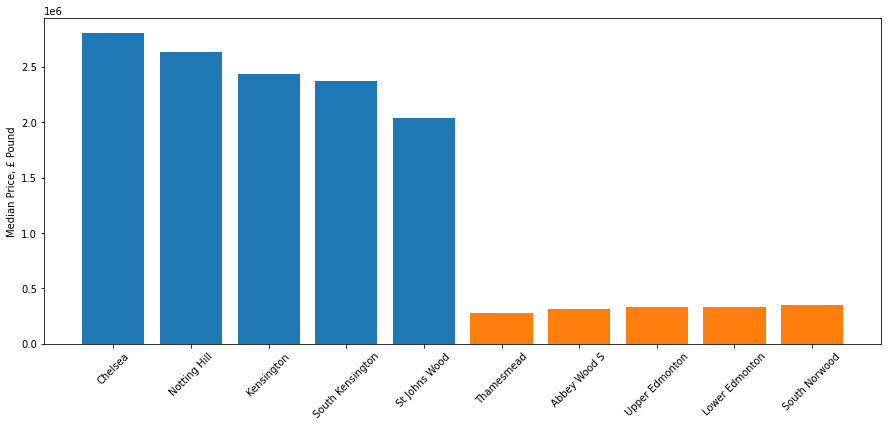

In [16]:
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
plt.rcParams['figure.figsize'] = (15,6)

fig = Figure()
ax = fig.add_subplot(121)
plt.bar(most_exp['Neighborhood'], most_exp['MedianPrice'])
plt.bar(least_exp['Neighborhood'], least_exp['MedianPrice'])
plt.xticks(rotation=45)
plt.ylabel('Median Price, £ Pound')
#plt.grid(True)

Let's visualize the whole dataset prices for each district

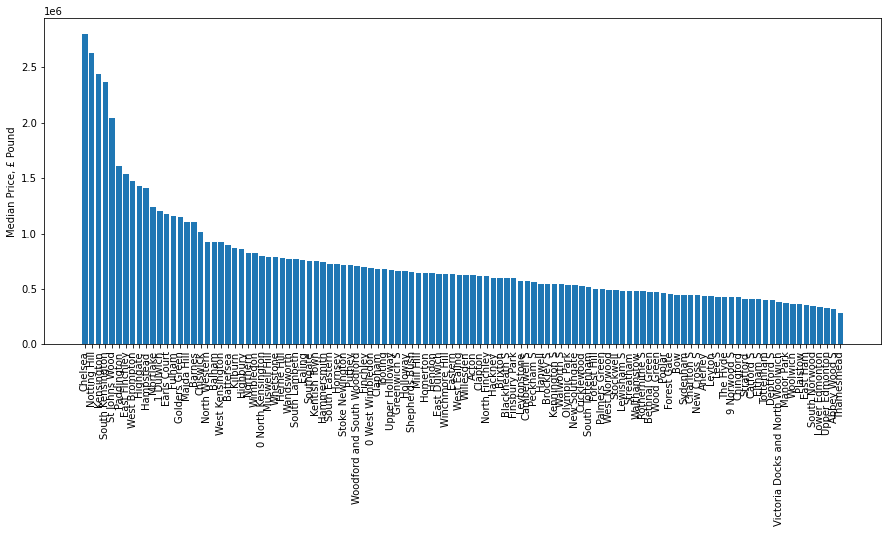

In [17]:
df_london_sorted = df_london.sort_values(by='MedianPrice',ascending=False)

fig = Figure()
ax = fig.add_subplot(111)
plt.bar(df_london_sorted['Neighborhood'], df_london_sorted['MedianPrice'])
plt.xticks(rotation='vertical')
plt.ylabel('Median Price, £ Pound')

plt.show()

Analysing the above chart we can try to identify 4 price categories such as:

<li>Very High Valued Properties</li>
<li>High Valued Properties</li>
<li>Medium Valued Properties</li>
<li>Low Valued Properties</li>

We can guess estimate where in these categories do each district fall into based solely on arbitrary housing price boundaries.

We will train the model, using the K-clustring algorithm, to identify the price category based on different metrics and identify under-valued properties.

We can visualise the 4 bands in the following bar chart


Text(65, 650000, 'Low Valued Properties')

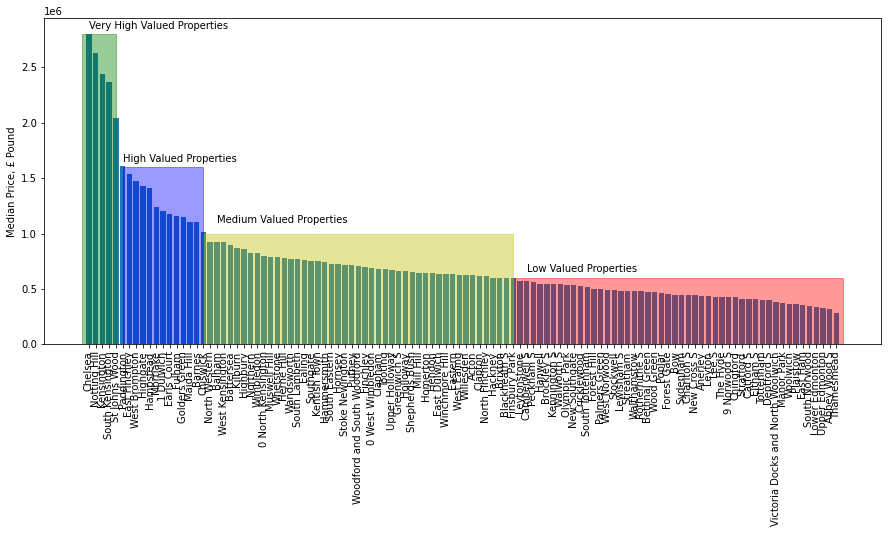

In [23]:
import matplotlib.patches as patches
# Create figure and axes
fig,ax = plt.subplots(1)
ax.bar(df_london_sorted['Neighborhood'], df_london_sorted['MedianPrice'])
plt.xticks(rotation='vertical')
plt.ylabel('Median Price, £ Pound')

rect1 = patches.Rectangle((63,0),49,600000,linewidth=1, alpha=.4, edgecolor='r',facecolor='r')
rect2 = patches.Rectangle((17,0),46,1000000,linewidth=1, alpha=.4, edgecolor='y',facecolor='y')
rect3 = patches.Rectangle((5,0),12,1600000,linewidth=1, alpha=.4, edgecolor='b',facecolor='b')
rect4 = patches.Rectangle((-1,0),5,2800000,linewidth=1, alpha=.4, edgecolor='g',facecolor='g')

# Add the patch to the Axes
ax.add_patch(rect1)
ax.add_patch(rect2)
ax.add_patch(rect3)
ax.add_patch(rect4)

ax.text(0,2850000, 'Very High Valued Properties')
ax.text(5,1650000, 'High Valued Properties')
ax.text(19,1100000, 'Medium Valued Properties')
ax.text(65,650000, 'Low Valued Properties')

Arbitrary Price boundaries set at (May be subject to iteration):
<li>(VH) Very High Valued Properties: > £1,600,000</li>
<li>(H) High Valued Properties: > £1,000,000 </li>
<li>(M) Medium Valued Properties: > £600,000 </li>
<li>(L) Low Valued Properties: < £600,000 </li>

Now let's add this categorical information in the dataset

In [25]:
price_cat = []
for i in range(0,len(df_london)):
    if df_london['MedianPrice'][i] >= 1600000:
        price_cat.append('VH')
    elif df_london['MedianPrice'][i] <1600000 and df_london['MedianPrice'][i] >= 1000000:
        price_cat.append('H')
    elif df_london['MedianPrice'][i] <1000000 and df_london['MedianPrice'][i] >= 600000:
        price_cat.append('M')
    elif df_london['MedianPrice'][i] < 600000:
        price_cat.append('L')

df_price_cat = pd.DataFrame(price_cat)
df_london['PriceCat'] = df_price_cat
df_london.head()

,PostalCode,District,Neighborhood,Latitude,Longitude,MedianPrice,PriceCat
0,E1,Eastern,Eastern,51.517388,-0.059488,633477,M
1,E2,Eastern,Bethnal Green,51.529604,-0.062598,472717,L
2,E3,Eastern,Bow,51.527949,-0.025267,446893,L
3,E4,Eastern,Chingford,51.621723,-0.005750,423602,L
4,E5,Eastern,Clapton,51.558879,-0.053755,614403,M


Now we have all the data cleaned and formatted we can proceed with clustering postcodes

<strong> The goal here is try to predict through clustering whether our machine learning algorithm can predict any of the neighborhoods to be in a different category then what has been classified (based on price above) using a metric based on local amenitities. </strong>

## Clustering neighborhoods in London

First define the foursquare API credentials

In [26]:
# @hidden_cell
CLIENT_ID = 'HRLRPPVSTBIFMF1A44WNHRAPREGMB35XKEDBXUHF40P0FA2W' # your Foursquare ID
CLIENT_SECRET = 'WWZGNWCIUEGGXPXN3EVP5M4QJ3LPWHUMBKMGRN05JW1SXISO' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
LIMIT = 100

Your credentails:
CLIENT_ID: HRLRPPVSTBIFMF1A44WNHRAPREGMB35XKEDBXUHF40P0FA2W
CLIENT_SECRET:WWZGNWCIUEGGXPXN3EVP5M4QJ3LPWHUMBKMGRN05JW1SXISO


From the Foursquare lab in the previous module, we know that all the information is in the *items* key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.

In [27]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Defining a function that would query to foursquare api information about each neighborhood.

In [31]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now we run the above funtion to obtain infromation about each neighborhood

In [32]:
London_venues = getNearbyVenues(names = df_london['Neighborhood'],
                                   latitudes = df_london['Latitude'],
                                   longitudes = df_london['Longitude']
                                  )

Eastern
Bethnal Green
Bow
Chingford
Clapton
East Ham
Forest Gate
Hackney
Homerton
Leyton
Leytonstone
Manor Park
Plaistow
Poplar
Stratford
Victoria Docks and North Woolwich
Walthamstow
Woodford and South Woodford
Olympic Park
Northern
East Finchley
Finchley
Finsbury Park
Highbury
Highgate
Holloway
Hornsey
Lower Edmonton
Muswell Hill
New Southgate
North Finchley
Palmers Green
Southgate
South Tottenham
Stoke Newington
Tottenham
Upper Edmonton
Upper Holloway
Whetstone
Winchmore Hill
Wood Green
North Western
Cricklewood
Hampstead
Hendon
Kentish Town
Kilburn
Mill Hill
St Johns Wood
The Hyde
Willesden
Golders Green
South Eastern
Abbey Wood S
Blackheath S
Brockley S
Camberwell S
Catford S
Charlton S
Deptford S
Eltham S
Greenwich S
Kennington S
Lee S
Lewisham S
New Cross S
Peckham S
Rotherhithe S
Walworth S
Woolwich
9 Norwood S
Anerley
1 Dulwich
East Dulwich
Forest Hill
Herne Hill
South Norwood
Sydenham
West Norwood
Thamesmead
Brixton
Chelsea
Clapham
Earls Court
Fulham
South Kensington
South La

Let's check the size and resulting dataframe

In [33]:
print(London_venues.shape)
London_venues.head()

(3435, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Eastern,51.517388,-0.059488,Mouse Tail Coffee Stories,51.519471,-0.058573,Coffee Shop
1,Eastern,51.517388,-0.059488,New Road Hotel,51.517575,-0.062658,Hotel
2,Eastern,51.517388,-0.059488,Tayyabs,51.517240,-0.063476,North Indian Restaurant
3,Eastern,51.517388,-0.059488,Needoo Grill,51.517070,-0.062379,Indian Restaurant
4,Eastern,51.517388,-0.059488,Lahore One,51.514725,-0.059399,Indian Restaurant


Now let's see how many venues have been output for each neighborhood

In [34]:
London_venues.groupby('Neighborhood').count().head(10)

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
0 North Kensington,12,12,12,12,12,12
0 West Wimbledon,33,33,33,33,33,33
1 Dulwich,9,9,9,9,9,9
9 Norwood S,41,41,41,41,41,41
Abbey Wood S,5,5,5,5,5,5
Acton,20,20,20,20,20,20
Anerley,8,8,8,8,8,8
Balham,50,50,50,50,50,50
Barnes,23,23,23,23,23,23


How many unique categories are available from the queried data

In [35]:
print('There are {} uniques categories.'.format(len(London_venues['Venue Category'].unique())))

There are 286 uniques categories.


## Now let's analyse each neighborhood

Let's use one hot encoding to categorize each neighborhood with all the different amenities category available

In [36]:
# one hot encoding
London_onehot = pd.get_dummies(London_venues[['Venue Category']], prefix="", prefix_sep="")

In [37]:
London_onehot['Neighborhood'] = London_venues['Neighborhood']
neigh = London_onehot['Neighborhood']
London_onehot.drop(labels=['Neighborhood'], axis=1,inplace = True)
London_onehot.insert(0, 'Neighborhood', neigh)
London_onehot.head()

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boarding House,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Canal,Canal Lock,Candy Store,Caribbean Restaurant,Casino,Caucasian Restaurant,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Cafeteria,College Quad,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cricket Ground,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Dumpling Restaurant,Electronics Store,English Restaurant,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Gelato Shop,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Hardware Store,Health & Beauty Service,Health Food Store,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Iraqi Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Lebanese Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nature Preserve,Nightclub,Noodle House,North Indian Restaurant,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Club,Roller Rink,Sake Bar,Salad Place,Sandwich Place,Scenic Lookout,School,Science Museum,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stationery Store,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tiki Bar,Tour Provider,Toy / Game Store,Trail,Train Station,Tunnel,Turkish Restaurant,University,Vegetarian / V

## Now let's group by neighborhood by taking the mean of the frequency of a particular category within the neighborhood

In [38]:
London_grouped = London_onehot.groupby('Neighborhood').mean().reset_index()
London_grouped.head()

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boarding House,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Canal,Canal Lock,Candy Store,Caribbean Restaurant,Casino,Caucasian Restaurant,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Cafeteria,College Quad,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cricket Ground,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Dumpling Restaurant,Electronics Store,English Restaurant,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Gelato Shop,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Hardware Store,Health & Beauty Service,Health Food Store,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Iraqi Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Lebanese Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nature Preserve,Nightclub,Noodle House,North Indian Restaurant,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Club,Roller Rink,Sake Bar,Salad Place,Sandwich Place,Scenic Lookout,School,Science Museum,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stationery Store,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tiki Bar,Tour Provider,Toy / Game Store,Trail,Train Station,Tunnel,Turkish Restaurant,University,Vegetarian / V

### Now let's output the 5 most common type of venues for each neighborhood

In [ ]:
num_top_venues = 5

for hood in London_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = London_grouped[London_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 4})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

Let's put the above into a dataframe

In [40]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [384]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = London_grouped['Neighborhood']

for ind in np.arange(London_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(London_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0 North Kensington,Café,Gym / Fitness Center,Furniture / Home Store,Middle Eastern Restaurant,Pizza Place,Pub,Park,Bar,Bakery,Supermarket
1,0 West Wimbledon,Bus Stop,Platform,Indian Restaurant,Pub,Café,Coffee Shop,Fast Food Restaurant,Grocery Store,Trail,Hotel
2,1 Dulwich,Flower Shop,Restaurant,Park,Bakery,Coffee Shop,Gym / Fitness Center,Garden Center,Wine Shop,Gift Shop,Fast Food Restaurant
3,9 Norwood S,Coffee Shop,Italian Restaurant,Pizza Place,Café,Gastropub,Pub,Thai Restaurant,Flea Market,Garden Center,Latin American Restaurant
4,Abbey Wood S,Supermarket,Platform,Grocery Store,Convenience Store,Coffee Shop,Yoga Studio,Event Space,Exhibit,Falafel Restaurant,Farm


## Now let's cluster the neighborhoods using the K-Means algorithm

We are using the k-means algorithm which is a unsupervised ML algorithm

In [385]:
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 20

London_grouped_clustering = London_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(London_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([ 7,  7, 19,  1, 17,  3,  3,  1,  1,  5])

Now add the cluster information in the dataframe

In [386]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

London_merged = df_london

# merge London_grouped with London_data to add latitude/longitude for each neighborhood
London_merged = London_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

London_merged.head() # check the last columns!

,PostalCode,District,Neighborhood,Latitude,Longitude,MedianPrice,PriceCat,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,E1,Eastern,Eastern,51.517388,-0.059488,633477,M,3,Hotel,Sandwich Place,Park,Pub,Indian Restaurant,Burger Joint,Grocery Store,Coffee Shop,Bakery,Ice Cream Shop
1,E2,Eastern,Bethnal Green,51.529604,-0.062598,472717,L,1,Pub,Coffee Shop,Cocktail Bar,Café,Italian Restaurant,Wine Bar,Flower Shop,Bar,Pizza Place,Yoga Studio
2,E3,Eastern,Bow,51.527949,-0.025267,446893,L,3,Pub,Hotel,Convenience Store,Bus Stop,Locksmith,Bar,Grocery Store,Park,Burger Joint,Exhibit
3,E4,Eastern,Chingford,51.621723,-0.005750,423602,L,10,English Restaurant,Gym,American Restaurant,Film Studio,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
4,E5,Eastern,Clapton,51.558879,-0.053755,614403,M,0,Grocery Store,Pub,Park,Coffee Shop,Gym / Fitness Center,Bus Stop,Burger Joint,Fried Chicken Joint,Martial Arts School,Garden


I want to try to classify the neighborhoods in 4 main classification depending on the type of top 10 local amenitites.
<li>(VH) Very High Valued Properties: > £1,600,000</li>
<li>(H) High Valued Properties: > £1,000,000 </li>
<li>(M) Medium Valued Properties: > £600,000 </li>
<li>(L) Low Valued Properties: < £600,000 </li>
    
<strong>So now I have a dataframe containing the "real data" under the column PriceCat indicating what the market assigned the neighborhood to under our category division (based on price alone) assumption. We can now compare this against what the K-mean algorithm output and see whther there is a mis-match in any neighborhood where the market data does not match with the cluster</strong>

In order to make a comparison on categories between predicted and actual we need to convert the cluster label into a meaningfull price category since these are just cluster based on local amenitites in the neighborhood. 

To do this we need to to the following:
<li>Divide our dataframe into 4 subsets corresponding to the 4 price categories</li>
<li>For each cateogry extract most frequent amenity based category (cluster label)</li>
<li>Now compare the amenity category of each neighborhood output from the algorithm to the one obtained in the above step</li>
<li>Identify any category difference and if so check to which type of neighborhood it has more similarity based on amenity</li>

In [387]:
df_VH = London_merged[London_merged['PriceCat'] == 'VH']
df_H = London_merged[London_merged['PriceCat'] == 'H']
df_M = London_merged[London_merged['PriceCat'] == 'M']
df_L = London_merged[London_merged['PriceCat'] == 'L']

VH_label = df_VH.describe().loc['75%']['Cluster Labels']
H_label = df_H.describe().loc['75%']['Cluster Labels']
M_label = df_M.describe().loc['75%']['Cluster Labels']
L_label = df_L.describe().loc['75%']['Cluster Labels']
print('The 75% percentile for the Very High valued neighborhood has cluster of {}'.format(VH_label))
print('The 75% percentile for the High valued neighborhood has cluster of {}'.format(H_label))
print('The 75% percentile for the Medium valued neighborhood has cluster of {}'.format(M_label))
print('The 75% percentile for the Low valued neighborhood has cluster of {}'.format(L_label))

The 75% percentile for the Very High valued neighborhood has cluster of 18.0
The 75% percentile for the High valued neighborhood has cluster of 9.75
The 75% percentile for the Medium valued neighborhood has cluster of 7.0
The 75% percentile for the Low valued neighborhood has cluster of 14.0


Now that we have the most typical label for a particular price category group we can compare how each individual neighborhood scored against this new parameter and whether confirm its place in the price category or if based on amentities alone it should be valued higher or lower

In [388]:
diff_VH = abs(London_merged['Cluster Labels'] - VH_label)
diff_H = abs(London_merged['Cluster Labels'] - H_label)
diff_M = abs(London_merged['Cluster Labels'] - M_label)
diff_L = abs(London_merged['Cluster Labels'] - L_label)

London_merged['diff_VH'] = diff_VH
London_merged['diff_H'] = diff_H
London_merged['diff_M'] = diff_M
London_merged['diff_L'] = diff_L

Predictions = London_merged[['diff_VH', 'diff_H','diff_M','diff_L']].min(axis=1)  
London_merged.insert(8, 'Predictions', Predictions)

#London_merged.drop(['diff_VH','diff_H', 'diff_M','diff_L'], axis=1,inplace=True)



In [390]:
prediction_list = []
for i in range(0, len(London_merged)):
    if London_merged['Predictions'][i] == London_merged['diff_VH'][i]:
        prediction_list.append('VH')
        
    elif London_merged['Predictions'][i] == London_merged['diff_H'][i]:
        prediction_list.append('H')
        
    elif London_merged['Predictions'][i] == London_merged['diff_M'][i]:
        prediction_list.append('M')
        
    elif London_merged['Predictions'][i] == London_merged['diff_L'][i]:
        prediction_list.append('L')
        
London_merged.drop(['Predictions'], inplace=True, axis=1)
#London_merged['Predictions'] = prediction_list

In [391]:
London_merged.insert(8, 'Predictions', prediction_list)

In [392]:
df_VH = London_merged[London_merged['PriceCat'] == 'VH']
df_H = London_merged[London_merged['PriceCat'] == 'H']
df_M = London_merged[London_merged['PriceCat'] == 'M']
df_L = London_merged[London_merged['PriceCat'] == 'L']
df_L.reset_index(inplace=True)
df_M.reset_index(inplace=True)
df_H.reset_index(inplace=True)
df_VH.reset_index(inplace=True)

### Now let's visualise the neighborhoods market value against the algorithm predictions.

To improve visibility we will split by neighborhood market value first.

## How to read the graphs:
For each of the Price category plot.
<li><b>Grey bar </b>: The neighborhood is predicted to be in the correct category based on amenities</li>
<li><b>Red bar </b>: The neighborhood is predicted to be in <b>Low Valued Property</b> </li>
<li><b>Yellow bar</b>: The neighborhood is predicted to be in <b>Medium Valued Property</b></li>
<li><b>Blue bar</b>: The neighborhood is predicted to be in <b>High Valued Property</b></li>
<li><b>Green bar</b>: The neighborhood is predicted to be in <b>Very High Valued Property</b></li>

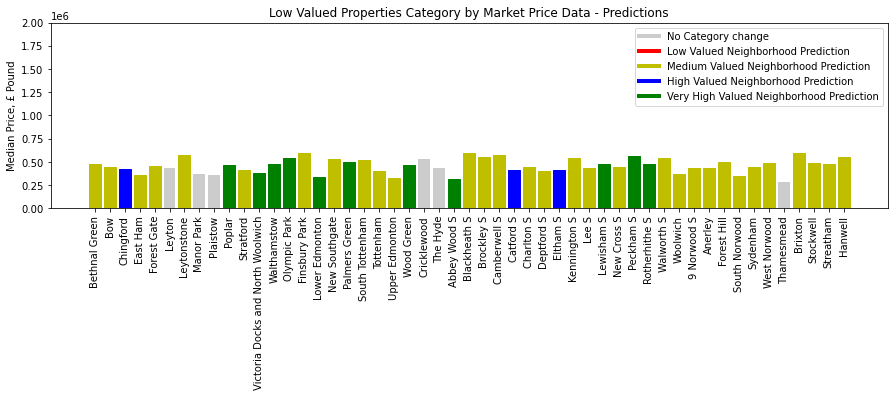

In [462]:
import matplotlib.patches as patches
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=(0.8,0.8,0.8,1), lw=4),
                Line2D([0], [0], color='r', lw=4),
                Line2D([0], [0], color='y', lw=4),
                Line2D([0], [0], color='b', lw=4),
                Line2D([0], [0], color='g', lw=4)]

# Create figure and axes
fig,ax = plt.subplots(1)
plotbar = ax.bar(df_L['Neighborhood'], df_L['MedianPrice'], color=(0.8,0.8,0.8,1))
plt.xticks(rotation='vertical')
plt.ylabel('Median Price, £ Pound')
plt.title('Low Valued Properties Category by Market Price Data - Predictions')
plt.legend('a')
# DEFINE COLOR MAP
# Green: is for VH Very High valued properties
# Blue: is for H High valued properties
# Yellow: is for Medium valued properties
# Red: is for low valued properties

M_indexes = df_L.index[df_L['Predictions'] == 'M'].tolist()
H_indexes = df_L.index[df_L['Predictions'] == 'H'].tolist()
VH_indexes = df_L.index[df_L['Predictions'] == 'VH'].tolist()

for i in range(0, len(M_indexes)):
     a= plotbar[M_indexes[i]].set_color('y')
for i in range(0, len(H_indexes)):
    b =plotbar[H_indexes[i]].set_color('b')
for i in range(0, len(VH_indexes)):
    c= plotbar[VH_indexes[i]].set_color('g')

df_color = pd.DataFrame(a,b,c)
ax.legend(custom_lines, ['No Category change', 'Low Valued Neighborhood Prediction', 'Medium Valued Neighborhood Prediction','High Valued Neighborhood Prediction', 'Very High Valued Neighborhood Prediction'])
ax.set_ylim([0,2000000])
plt.gcf().subplots_adjust(bottom=0.45)
plt.savefig('LowValued.png')
plt.show()

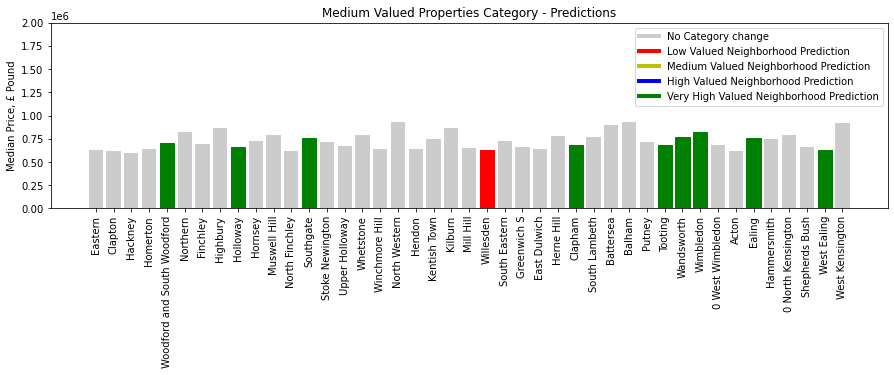

In [463]:
# Create figure and axes
fig,ax = plt.subplots(1)
plotbar = ax.bar(df_M['Neighborhood'], df_M['MedianPrice'], color=(0.8,0.8,0.8,1))
plt.xticks(rotation='vertical')
plt.ylabel('Median Price, £ Pound')
plt.title('Medium Valued Properties Category - Predictions')

# DEFINE COLOR MAP
# Green: is for VH Very High valued properties
# Blue: is for H High valued properties
# Yellow: is for Medium valued properties
# Red: is for low valued properties

L_indexes = df_M.index[df_M['Predictions'] == 'L'].tolist()
H_indexes = df_M.index[df_M['Predictions'] == 'H'].tolist()
VH_indexes = df_M.index[df_M['Predictions'] == 'VH'].tolist()

for i in range(0, len(L_indexes)):
    plotbar[L_indexes[i]].set_color('r')
for i in range(0, len(H_indexes)):
    plotbar[H_indexes[i]].set_color('b')
for i in range(0, len(VH_indexes)):
    plotbar[VH_indexes[i]].set_color('g')
    
ax.legend(custom_lines, ['No Category change', 'Low Valued Neighborhood Prediction', 'Medium Valued Neighborhood Prediction','High Valued Neighborhood Prediction', 'Very High Valued Neighborhood Prediction'])
ax.set_ylim([0,2000000])
plt.gcf().subplots_adjust(bottom=0.45)
plt.savefig('MediumValued.png')
plt.show()

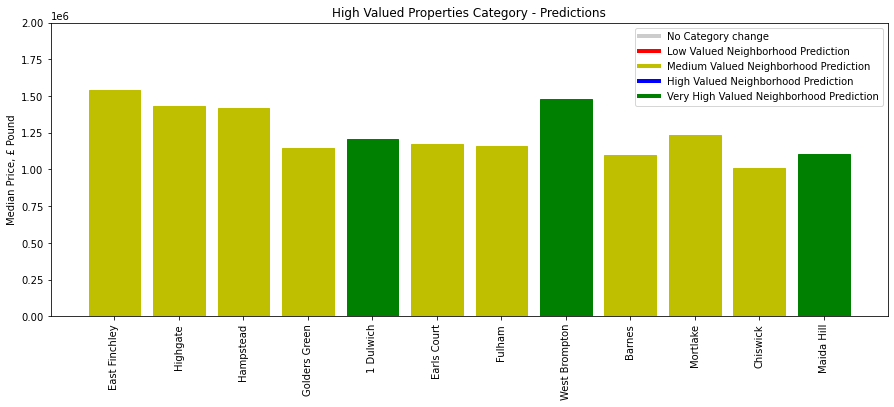

In [468]:
# Create figure and axes
fig,ax = plt.subplots(1)
plotbar = ax.bar(df_H['Neighborhood'], df_H['MedianPrice'], color=(0.8,0.8,0.8,1))
plt.xticks(rotation='vertical')
plt.ylabel('Median Price, £ Pound')
plt.title('High Valued Properties Category - Predictions')

# DEFINE COLOR MAP
# Green: is for VH Very High valued properties
# Blue: is for H High valued properties
# Yellow: is for Medium valued properties
# Red: is for low valued properties

L_indexes = df_H.index[df_H['Predictions'] == 'L'].tolist()
M_indexes = df_H.index[df_H['Predictions'] == 'M'].tolist()
VH_indexes = df_H.index[df_H['Predictions'] == 'VH'].tolist()

for i in range(0, len(L_indexes)):
    plotbar[L_indexes[i]].set_color('r')
for i in range(0, len(M_indexes)):
    plotbar[M_indexes[i]].set_color('y')
for i in range(0, len(VH_indexes)):
    plotbar[VH_indexes[i]].set_color('g')
    
ax.legend(custom_lines, ['No Category change', 'Low Valued Neighborhood Prediction', 'Medium Valued Neighborhood Prediction','High Valued Neighborhood Prediction', 'Very High Valued Neighborhood Prediction'])
ax.set_ylim([0,2000000])
plt.gcf().subplots_adjust(bottom=0.2)
plt.savefig('HighValued.png')
plt.show()

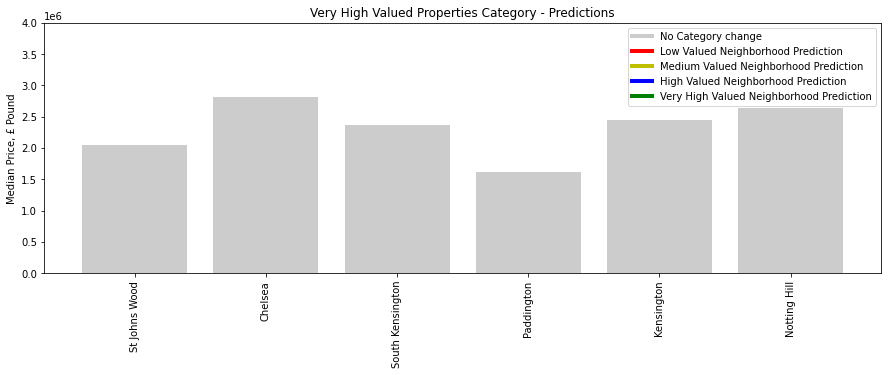

In [469]:
# Create figure and axes
fig,ax = plt.subplots(1)
plotbar = ax.bar(df_VH['Neighborhood'], df_VH['MedianPrice'], color=(0.8,0.8,0.8,1))
plt.xticks(rotation='vertical')
plt.ylabel('Median Price, £ Pound')
plt.title('Very High Valued Properties Category - Predictions')
# DEFINE COLOR MAP
# Green: is for VH Very High valued properties
# Blue: is for H High valued properties
# Yellow: is for Medium valued properties
# Red: is for low valued properties

L_indexes = df_VH.index[df_VH['Predictions'] == 'L'].tolist()
M_indexes = df_VH.index[df_VH['Predictions'] == 'M'].tolist()
H_indexes = df_VH.index[df_VH['Predictions'] == 'H'].tolist()

for i in range(0, len(L_indexes)):
    plotbar[L_indexes[i]].set_color('r')
for i in range(0, len(M_indexes)):
    plotbar[M_indexes[i]].set_color('y')
for i in range(0, len(H_indexes)):
    plotbar[H_indexes[i]].set_color('b')

ax.legend(custom_lines, ['No Category change', 'Low Valued Neighborhood Prediction', 'Medium Valued Neighborhood Prediction','High Valued Neighborhood Prediction', 'Very High Valued Neighborhood Prediction'])
ax.set_ylim([0,4000000])
plt.gcf().subplots_adjust(bottom=0.3)
plt.savefig('VeryHighValued.png')
plt.show()

## Now let's visualise this on a map

In [402]:
!pip install folium
import folium
from geopy.geocoders import Nominatim
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

In [403]:
London_merged.dropna(inplace=True)

In [404]:
# create map
map_clusters = folium.Map(location=[51.5074, -0.1278], zoom_start=11) 
London_merged['Cluster Labels']= London_merged['Cluster Labels'].astype(int)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the madrp
markers_colors = []
for lat, lon, poi, post,cluster in zip(London_merged['Latitude'], London_merged['Longitude'], London_merged['Neighborhood'], London_merged['PostalCode'], London_merged['Cluster Labels']):
    label = folium.Popup(str(poi) +', PostCode '+ str(post) +', Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters